In [285]:
from __future__ import annotations
import numpy as np
from queue import Queue, PriorityQueue
from copy import deepcopy
from collections import defaultdict
from itertools import count
import math
import pickle


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme(style="darkgrid")


import time

In [87]:
class Matrix:
    def __init__(self, path: str):
        self.num_elements = 1
        self.init(path)
        self.moving_column = None
        self.moving_options = list()
        self.already_moved = set()

    def init(self, path: str):
        file = open(path, "r")
        lines = [
            [e.replace("' '", " ").replace("'", "") for e in line.strip().split(",")]
            for line in file
        ]
        self.top_positions = defaultdict(lambda: len(lines), dict())
        self.height = len(lines)
        self.width = len(lines[0])
        self.data = lines
        self.compute_top_positions()

    def compute_top_positions(self):
        self.top_positions = defaultdict(lambda: self.height, dict())
        for i, row in enumerate(self.data):
            for j, e in enumerate(row):
                if e != " " and self.top_positions[j] == self.height:
                    self.top_positions[j] = i

    def __repr__(self):
        return "\n".join([str([e for e in row]) for row in self.data])

    def get_positions_on_top(self) -> dict:
        return {i: self.top_positions[i] for i in range(self.width)}

    def get_next_move(self) -> tuple:
        top = self.get_positions_on_top()
        if len(self.moving_options) == 0:
            self.moving_column = self.get_next_move_column()
        if self.moving_column is not None and len(self.moving_options) == 0:
            self.moving_options = [
                (k, v - 1) for k, v in top.items() if k != self.moving_column and v > 0
            ]
        if len(self.moving_options) > 0:
            to_move = self.moving_options[0]
            self.moving_options = self.moving_options[1:]
            return to_move
        else:
            self.moving_column = None
        return None

    def get_next_move_column(self) -> int:
        top = self.get_positions_on_top()
        for k, v in top.items():
            if k not in self.already_moved and self.height > v:
                self.already_moved.add(k)
                return k
        return None

    def copy(self) -> Matrix:
        temp = deepcopy(self)
        temp.moving_column = None
        temp.moving_options = list()
        temp.already_moved = set()
        return temp

    def swap(self, x: tuple, y: tuple):
        temp = self.data[x[1]][x[0]]
        self.data[x[1]][x[0]] = self.data[y[1]][y[0]]
        self.data[y[1]][y[0]] = temp
        self.compute_top_positions()

    def distance(self, a: tuple, b: tuple, p: str) -> float:
        if p == "manhattan":
            return sum(abs(e1 - e2) for e1, e2 in zip(a, b))
        elif p == "euclidean":
            return sum(abs(e1 - e2) ** 2 for e1, e2 in zip(a, b)) ** (1 / 2)
        elif p == "column":
            return abs(b[1] - a[1])
        elif p == "row":
            return abs(b[0] - a[0])

    def get_index(self, e: str) -> tuple:
        for row in self.data:
            if e in row:
                return (self.data.index(row), row.index(e))
        return None

    def calculate_distances(self, start: Node, end: Node, p: str) -> tuple:
        h, g = 0, 0
        for i, row in enumerate(self.data):
            for j, e in enumerate(row):
                if e != " ":
                    if p != "misplaced":
                        si, sj = start.item.get_index(e)
                        ei, ej = end.item.get_index(e)
                        g += self.distance((i, j), (si, sj), p)
                        h += self.distance((i, j), (ei, ej), p)
                    else:
                        if e != end.item.data[i][j]:
                            h += i
                        if e != start.item.data[i][j]:
                            g += 1
        return g, h

In [88]:
class Node:
    def __init__(self, parent: Node, item: Matrix, level: int):
        self.parent = parent
        self.item = item
        self.children = list()
        self.level = level
        self.move_made = None
        self.h = 0
        self.g = 0
        self.f = 0

    def __repr__(self):
        return str(self.item)


In [89]:
class Graph:
    def __init__(self, start: Matrix, target: Matrix):
        self.root = Node(None, deepcopy(start), 0)
        self.node_values = set()
        self.target = Node(None, deepcopy(target), -1)
        self.total_nodes = 0
        self.total_in_memory = 0
        self.max_memory = 0

    def from_node_to_root(self, node: Node) -> list:
        nodes = list()
        while node:
            nodes.append(node)
            node = node.parent
        return nodes[::-1]

    def develop_next(self, node: Node) -> tuple:
        new_node = node
        while str(list(new_node.item.data)) in self.node_items:
            move = node.item.get_next_move()
            if move is not None:
                new_node = Node(node, node.item.copy(), node.level + 1)
                top = node.item.get_positions_on_top()
                new_node.item.swap(
                    move, (node.item.moving_column, top[node.item.moving_column])
                )
            else:
                return False, None
        self.node_items.add(str(list(new_node.item.data)))
        node.children.append(new_node)
        self.total_nodes += 1
        return new_node, (node.item.moving_column, move[0])

In [90]:
data = {
    1: {
        "start": Matrix("./primeri/primer1_zacetna.txt"),
        "target": Matrix("./primeri/primer1_koncna.txt"),
    },
    2: {
        "start": Matrix("./primeri/primer2_zacetna.txt"),
        "target": Matrix("./primeri/primer2_koncna.txt"),
    },
    3: {
        "start": Matrix("./primeri/primer3_zacetna.txt"),
        "target": Matrix("./primeri/primer3_koncna.txt"),
    },
    4: {
        "start": Matrix("./primeri/primer4_zacetna.txt"),
        "target": Matrix("./primeri/primer4_koncna.txt"),
    },
    5: {
        "start": Matrix("./primeri/primer5_zacetna.txt"),
        "target": Matrix("./primeri/primer5_koncna.txt"),
    },
}

In [17]:
res = defaultdict(dict)

# BFS

In [18]:
class BFS(Graph):
    def __init__(self, start: Matrix, target: Matrix):
        super().__init__(start, target)
        self.queue = Queue()
        self.queue.put(self.root)
        self.node_items = set()
        self.node_items.add(str(list(self.root.item.data)))

    def solve(self) -> list:
        while not self.queue.empty():
            self.max_memory = max(self.max_memory, self.queue.qsize())
            node = self.queue.get()
            new_node = node
            while new_node:
                new_node, move = self.develop_next(node)
                if new_node:
                    new_node.move_made = move
                    if list(new_node.item.data) == list(self.target.item.data):
                        return self.from_node_to_root(new_node), self.queue.qsize() + 1
                    elif new_node:
                        self.queue.put(new_node)
        return []

In [19]:
for k, v in data.items():
    g = BFS(v["start"], v["target"])
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["bfs"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.00798  |  Steps:          5  |  Total nodes generated:         54  |  Nodes in memory:         20  |  Max. nodes in memory: 20 
Case: 2  |  Time:    0.13863  |  Steps:          9  |  Total nodes generated:        797  |  Nodes in memory:        242  |  Max. nodes in memory: 241 
Case: 3  |  Time:     5.8743  |  Steps:          8  |  Total nodes generated:      21825  |  Nodes in memory:      10904  |  Max. nodes in memory: 10904 
Case: 4  |  Time:   16.00621  |  Steps:         12  |  Total nodes generated:      32399  |  Nodes in memory:         21  |  Max. nodes in memory: 10691 
Case: 5  |  Time:   40.08436  |  Steps:          8  |  Total nodes generated:      99361  |  Nodes in memory:      47870  |  Max. nodes in memory: 47872 


# DFS

In [20]:
class DFS(Graph):
    def __init__(self, start: Matrix, target: Matrix):
        super().__init__(start, target)
        self.stack = list()
        self.stack.append(self.root)
        self.node_items = set()
        self.node_items.add(str(list(self.root.item.data)))

    def solve(self) -> list:
        while len(self.stack) > 0:
            self.max_memory = max(self.max_memory, len(self.stack))
            node = self.stack.pop()
            new_node = node
            new_nodes = list()
            while new_node:
                new_node, move = self.develop_next(node)
                if new_node:
                    new_node.move_made = move
                    if list(new_node.item.data) == list(self.target.item.data):
                        return self.from_node_to_root(new_node), len(self.stack) + 1
                    elif new_node:
                        new_nodes.append(new_node)
            self.stack.extend(new_nodes[::-1])
        return []

In [21]:
for k, v in data.items():
    g = DFS(v["start"], v["target"])
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["dfs"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.00598  |  Steps:          9  |  Total nodes generated:         23  |  Nodes in memory:         14  |  Max. nodes in memory: 14 
Case: 2  |  Time:    0.13663  |  Steps:        398  |  Total nodes generated:       1074  |  Nodes in memory:        570  |  Max. nodes in memory: 570 
Case: 3  |  Time:    4.26061  |  Steps:       6443  |  Total nodes generated:      29060  |  Nodes in memory:      22507  |  Max. nodes in memory: 22507 
Case: 4  |  Time:    4.28355  |  Steps:       7071  |  Total nodes generated:      29922  |  Nodes in memory:      21610  |  Max. nodes in memory: 21610 
Case: 5  |  Time:    0.02294  |  Steps:         29  |  Total nodes generated:        272  |  Nodes in memory:        241  |  Max. nodes in memory: 241 


# IDDFS

In [23]:
class IDDFS(Graph):
    def __init__(self, start: Matrix, target: Matrix):
        super().__init__(start, target)
        self.max_depth = 1
        self.temp_stack = []

    def solve(self):
        res = self.solve_iterative()
        while not res:
            self.max_depth += 1
            res = self.solve_iterative()
        return res

    def solve_iterative(self) -> list:
        self.root.children = []
        self.root.item.already_moved = set()
        self.stack = list()
        self.stack.append(self.root)
        self.temp_stack = [str(list(self.root.item.data))]
        while len(self.stack) > 0:
            self.max_memory = max(self.max_memory, len(self.stack))
            node = self.stack.pop()
            self.temp_stack = self.temp_stack[: node.level]
            self.temp_stack.append(str(list(node.item.data)))
            new_node = node
            new_nodes = list()
            while new_node:
                new_node, move = self.develop_next(node)
                if new_node and new_node.level > self.max_depth:
                    break
                if new_node:
                    new_node.move_made = move
                    if list(new_node.item.data) == list(self.target.item.data):
                        return self.from_node_to_root(new_node), len(self.stack) + 1
                    elif new_node:
                        new_nodes.append(new_node)
            self.stack.extend(new_nodes[::-1])
        return None

    def develop_next(self, node: Node) -> tuple:
        if node.level + 1 > self.max_depth:
            return False, None
        new_node = node
        while str(list(new_node.item.data)) in self.temp_stack or new_node == node:
            move = node.item.get_next_move()
            if move is not None:
                new_node = Node(node, node.item.copy(), node.level + 1)
                top = node.item.get_positions_on_top()
                new_node.item.swap(
                    move, (node.item.moving_column, top[node.item.moving_column])
                )
            else:
                return False, None
        node.children.append(new_node)
        self.total_nodes += 1
        return new_node, (node.item.moving_column, move[0])

In [24]:
for k, v in data.items():
    if k > 3:
        break
    g = IDDFS(v["start"], v["target"])
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["iddfs"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.03092  |  Steps:          5  |  Total nodes generated:        335  |  Nodes in memory:          8  |  Max. nodes in memory: 13 
Case: 2  |  Time:    2.56714  |  Steps:          9  |  Total nodes generated:      29082  |  Nodes in memory:         13  |  Max. nodes in memory: 25 
Case: 3  |  Time:  534.98595  |  Steps:          8  |  Total nodes generated:    6841338  |  Nodes in memory:         37  |  Max. nodes in memory: 71 


# A*

In [91]:
class AStar(Graph):
    def __init__(self, start: Matrix, target: Matrix, distance_type=1):
        super().__init__(start, target)
        self.distance_type = distance_type
        self.open = PriorityQueue()
        self.closed = set()
        self.calculate_distance(self.root)
        self.open.put((self.root.f, self.root))
        self.open_dict = {str(list(self.root.item.data)): self.root}
        self.closed_dict = dict()
        self.unique = count()

    def calculate_distance(self, node: Node):
        g, h = node.item.calculate_distances(self.root, self.target, self.distance_type)
        if node.parent:
            g += node.parent.g
        node.h = h
        node.g = g
        node.f = h + g

    def generate_children(self, node: Node) -> list:
        children = list()
        node.item.already_moved = set()
        node.item.moving_options = list()
        node.item.moving_column = None
        new_node = node
        while new_node:
            new_node, move = self.develop_next(node)
            if new_node:
                new_node.move_made = move
                self.calculate_distance(new_node)
                children.append(new_node)
        return children

    def develop_next(self, node: Node) -> tuple:
        new_node = node
        move = node.item.get_next_move()
        if move is not None:
            new_node = Node(node, node.item.copy(), node.level + 1)
            top = node.item.get_positions_on_top()
            new_node.item.swap(
                move, (node.item.moving_column, top[node.item.moving_column])
            )
        else:
            return False, None
        node.children.append(new_node)
        self.total_nodes += 1
        return new_node, (node.item.moving_column, move[0])

    def solve(self) -> list:
        while not self.open.empty():
            self.max_memory = max(self.max_memory, len(self.closed) + self.open.qsize())
            _, q = self.open.get()

            self.open_dict.pop(str(list(q.item.data)), None)

            if list(q.item.data) == list(self.target.item.data):
                return (
                    self.from_node_to_root(q),
                    self.open.qsize() + len(self.closed) + 1,
                )

            children = self.generate_children(q)
            for e in children:
                temp = str(list(e.item.data))
                if temp in self.open_dict and e.g < self.open_dict[temp].g:
                    self.open_dict[temp].parent = q
                    self.total_nodes -= 1

                elif temp not in self.open_dict and temp not in self.closed_dict:
                    self.open_dict[temp] = e
                    self.open.put(((e.f, e.h, e.g, next(self.unique)), e))

            self.closed_dict[str(list(q.item.data))] = q
            self.closed.add(q)

In [26]:
for k, v in data.items():
    g = AStar(v["start"], v["target"], "row")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["a_star_row"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.00698  |  Steps:          5  |  Total nodes generated:         98  |  Nodes in memory:         50  |  Max. nodes in memory: 50 
Case: 2  |  Time:     0.1506  |  Steps:          9  |  Total nodes generated:       2274  |  Nodes in memory:        785  |  Max. nodes in memory: 785 
Case: 3  |  Time:    5.46938  |  Steps:         12  |  Total nodes generated:      71555  |  Nodes in memory:      21764  |  Max. nodes in memory: 21764 
Case: 4  |  Time:   20.09229  |  Steps:         12  |  Total nodes generated:     305994  |  Nodes in memory:      32400  |  Max. nodes in memory: 32400 
Case: 5  |  Time:  135.81296  |  Steps:          9  |  Total nodes generated:    1404254  |  Nodes in memory:     133185  |  Max. nodes in memory: 133185 


In [27]:
for k, v in data.items():
    g = AStar(v["start"], v["target"], "column")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["a_star_column"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.02094  |  Steps:          5  |  Total nodes generated:        139  |  Nodes in memory:         56  |  Max. nodes in memory: 56 
Case: 2  |  Time:    0.16256  |  Steps:         12  |  Total nodes generated:       1803  |  Nodes in memory:        716  |  Max. nodes in memory: 716 
Case: 3  |  Time:   21.47709  |  Steps:         11  |  Total nodes generated:     284061  |  Nodes in memory:      46132  |  Max. nodes in memory: 46132 
Case: 4  |  Time:    9.19243  |  Steps:         12  |  Total nodes generated:      21267  |  Nodes in memory:       6641  |  Max. nodes in memory: 6641 
Case: 5  |  Time:    16.9831  |  Steps:         11  |  Total nodes generated:     164543  |  Nodes in memory:      42097  |  Max. nodes in memory: 42097 


In [92]:
for k, v in data.items():
    g = AStar(v["start"], v["target"], "misplaced")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["a_star_misplaced"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.00598  |  Steps:          5  |  Total nodes generated:        102  |  Nodes in memory:         44  |  Max. nodes in memory: 44 
Case: 2  |  Time:    0.19448  |  Steps:          9  |  Total nodes generated:       2610  |  Nodes in memory:        917  |  Max. nodes in memory: 917 
Case: 3  |  Time:    3.07138  |  Steps:          8  |  Total nodes generated:      46860  |  Nodes in memory:      14119  |  Max. nodes in memory: 14119 
Case: 4  |  Time:   24.86224  |  Steps:         12  |  Total nodes generated:     314652  |  Nodes in memory:      32400  |  Max. nodes in memory: 32400 
Case: 5  |  Time:   17.96144  |  Steps:          8  |  Total nodes generated:     221227  |  Nodes in memory:      49711  |  Max. nodes in memory: 49711 


In [29]:
for k, v in data.items():
    g = AStar(v["start"], v["target"], "manhattan")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["a_star_manhattan"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.01097  |  Steps:          5  |  Total nodes generated:        148  |  Nodes in memory:         58  |  Max. nodes in memory: 58 
Case: 2  |  Time:     0.1875  |  Steps:          9  |  Total nodes generated:       2227  |  Nodes in memory:        798  |  Max. nodes in memory: 798 
Case: 3  |  Time:   25.16074  |  Steps:          8  |  Total nodes generated:     236676  |  Nodes in memory:      44169  |  Max. nodes in memory: 44169 
Case: 4  |  Time:   10.22816  |  Steps:         12  |  Total nodes generated:     107570  |  Nodes in memory:      22051  |  Max. nodes in memory: 22051 
Case: 5  |  Time:   49.97194  |  Steps:          9  |  Total nodes generated:     478943  |  Nodes in memory:      87551  |  Max. nodes in memory: 87551 


In [30]:
for k, v in data.items():
    g = AStar(v["start"], v["target"], "euclidean")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["a_star_euclidean"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.01895  |  Steps:          5  |  Total nodes generated:        154  |  Nodes in memory:         58  |  Max. nodes in memory: 58 
Case: 2  |  Time:    0.21542  |  Steps:          9  |  Total nodes generated:       2244  |  Nodes in memory:        799  |  Max. nodes in memory: 799 
Case: 3  |  Time:   21.87322  |  Steps:          8  |  Total nodes generated:     183221  |  Nodes in memory:      38063  |  Max. nodes in memory: 38063 
Case: 4  |  Time:   15.53251  |  Steps:         12  |  Total nodes generated:     154449  |  Nodes in memory:      27786  |  Max. nodes in memory: 27786 
Case: 5  |  Time:   54.17519  |  Steps:          9  |  Total nodes generated:     483756  |  Nodes in memory:      85407  |  Max. nodes in memory: 85407 


# Hill climbing

In [93]:
class HillClimbing(Graph):
    def __init__(self, start: Matrix, target: Matrix, distance_type=1):
        super().__init__(start, target)
        self.distance_type = distance_type
        self.calculate_distance(self.root)
        self.stack = [self.root]
        self.node_items = {str(list(self.root.item.data))}

    def calculate_distance(self, node: Node):
        _, h = node.item.calculate_distances(self.root, self.target, self.distance_type)
        node.h = h

    def generate_children(self, node: Node) -> list:
        children = list()
        new_node = node
        while new_node:
            new_node, move = self.develop_next(node)
            if new_node:
                new_node.move_made = move
                self.calculate_distance(new_node)
                children.append(new_node)
        return children

    def solve(self) -> list:
        while len(self.stack):
            self.max_memory = max(self.max_memory, len(self.stack))
            q = self.stack.pop()
            if list(q.item.data) == list(self.target.item.data):
                return self.from_node_to_root(q), len(self.stack) + 1
            children = self.generate_children(q)
            children.sort(key=lambda x: x.h, reverse=True)
            self.stack.extend(children)

In [94]:
for k, v in data.items():
    g = HillClimbing(v["start"], v["target"], "row")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["hill_climbing_row"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.00199  |  Steps:          6  |  Total nodes generated:         16  |  Nodes in memory:         10  |  Max. nodes in memory: 10 
Case: 2  |  Time:     0.3002  |  Steps:         57  |  Total nodes generated:       1431  |  Nodes in memory:        121  |  Max. nodes in memory: 652 
Case: 3  |  Time:    0.25682  |  Steps:        360  |  Total nodes generated:       2278  |  Nodes in memory:       1919  |  Max. nodes in memory: 1919 
Case: 4  |  Time:    0.28076  |  Steps:        491  |  Total nodes generated:       2652  |  Nodes in memory:       2162  |  Max. nodes in memory: 2162 
Case: 5  |  Time:    0.53409  |  Steps:        710  |  Total nodes generated:       4139  |  Nodes in memory:       3429  |  Max. nodes in memory: 3429 


In [95]:
for k, v in data.items():
    g = HillClimbing(v["start"], v["target"], "column")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["hill_climbing_column"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.00449  |  Steps:         11  |  Total nodes generated:         32  |  Nodes in memory:         17  |  Max. nodes in memory: 17 
Case: 2  |  Time:    0.15359  |  Steps:        443  |  Total nodes generated:       1121  |  Nodes in memory:        532  |  Max. nodes in memory: 532 
Case: 3  |  Time:    0.24036  |  Steps:        396  |  Total nodes generated:       2157  |  Nodes in memory:       1761  |  Max. nodes in memory: 1761 
Case: 4  |  Time:    0.19747  |  Steps:        326  |  Total nodes generated:       1835  |  Nodes in memory:       1510  |  Max. nodes in memory: 1510 
Case: 5  |  Time:    0.71661  |  Steps:        973  |  Total nodes generated:       6016  |  Nodes in memory:       5044  |  Max. nodes in memory: 5044 


In [96]:
for k, v in data.items():
    g = HillClimbing(v["start"], v["target"], "misplaced")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["hill_climbing_misplaced"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.00199  |  Steps:          8  |  Total nodes generated:         20  |  Nodes in memory:         10  |  Max. nodes in memory: 10 
Case: 2  |  Time:    0.00798  |  Steps:         18  |  Total nodes generated:         42  |  Nodes in memory:         25  |  Max. nodes in memory: 25 
Case: 3  |  Time:    0.01097  |  Steps:         20  |  Total nodes generated:         81  |  Nodes in memory:         62  |  Max. nodes in memory: 62 
Case: 4  |  Time:    0.05984  |  Steps:        115  |  Total nodes generated:        629  |  Nodes in memory:        515  |  Max. nodes in memory: 515 
Case: 5  |  Time:    0.12666  |  Steps:        165  |  Total nodes generated:        901  |  Nodes in memory:        737  |  Max. nodes in memory: 737 


In [35]:
for k, v in data.items():
    g = HillClimbing(v["start"], v["target"], "manhattan")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["hill_climbing_manhattan"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.00199  |  Steps:          8  |  Total nodes generated:         20  |  Nodes in memory:         12  |  Max. nodes in memory: 12 
Case: 2  |  Time:    0.02793  |  Steps:         87  |  Total nodes generated:        251  |  Nodes in memory:        161  |  Max. nodes in memory: 161 
Case: 3  |  Time:    0.06782  |  Steps:         95  |  Total nodes generated:        630  |  Nodes in memory:        536  |  Max. nodes in memory: 536 
Case: 4  |  Time:    0.08178  |  Steps:        136  |  Total nodes generated:        829  |  Nodes in memory:        694  |  Max. nodes in memory: 694 
Case: 5  |  Time:    0.93251  |  Steps:       1093  |  Total nodes generated:       6758  |  Nodes in memory:       5666  |  Max. nodes in memory: 5666 


In [97]:
for k, v in data.items():
    g = HillClimbing(v["start"], v["target"], "euclidean")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )
    res["hill_climbing_euclidean"][k] = {
        "time": round(total, 5),
        "path": [str(e) for e in nodes],
        "moves": [e.move_made for e in nodes],
        "number_of_steps": len(nodes) - 1,
        "mem_usage": mem,
        "max_mem_usage": g.max_memory,
    }

Case: 1  |  Time:    0.00299  |  Steps:         11  |  Total nodes generated:         33  |  Nodes in memory:         17  |  Max. nodes in memory: 17 
Case: 2  |  Time:    0.01596  |  Steps:         54  |  Total nodes generated:        152  |  Nodes in memory:         96  |  Max. nodes in memory: 96 
Case: 3  |  Time:    0.19997  |  Steps:        238  |  Total nodes generated:       1542  |  Nodes in memory:       1305  |  Max. nodes in memory: 1305 
Case: 4  |  Time:    0.02693  |  Steps:         48  |  Total nodes generated:        289  |  Nodes in memory:        242  |  Max. nodes in memory: 242 
Case: 5  |  Time:    0.10622  |  Steps:        133  |  Total nodes generated:        818  |  Nodes in memory:        686  |  Max. nodes in memory: 686 


# Best first

In [98]:
class BestFirst(Graph):
    def __init__(self, start: Matrix, target: Matrix, distance_type=1):
        super().__init__(start, target)
        self.distance_type = distance_type
        self.calculate_distance(self.root)
        self.queue = PriorityQueue()
        self.queue.put((0, self.root))
        self.node_items = {str(list(self.root.item.data))}
        self.unique = count()

    def calculate_distance(self, node: Node):
        g, h = node.item.calculate_distances(self.root, self.target, self.distance_type)
        node.h = h

    def generate_children(self, node: Node) -> list:
        children = list()
        new_node = node
        while new_node:
            new_node, move = self.develop_next(node)
            if new_node:
                new_node.move_made = move
                self.calculate_distance(new_node)
                children.append(new_node)
        return children

    def solve(self) -> list:
        while not self.queue.empty():
            self.max_memory = max(self.max_memory, self.queue.qsize())
            _, q = self.queue.get()
            if list(q.item.data) == list(self.target.item.data):
                return self.from_node_to_root(q), self.queue.qsize() + 1
            children = self.generate_children(q)
            for e in children:
                self.queue.put(((e.h, next(self.unique)), e))

In [103]:
for k, v in data.items():
    g = BestFirst(v["start"], v["target"], "row")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )

res["best_first_row"][k] = {
    "time": round(total, 5),
    "path": [str(e) for e in nodes],
    "moves": [e.move_made for e in nodes],
    "number_of_steps": len(nodes) - 1,
    "mem_usage": mem,
    "max_mem_usage": g.max_memory,
}

Case: 1  |  Time:    0.00598  |  Steps:          6  |  Total nodes generated:         43  |  Nodes in memory:         19  |  Max. nodes in memory: 19 
Case: 2  |  Time:    0.09924  |  Steps:         12  |  Total nodes generated:        465  |  Nodes in memory:        203  |  Max. nodes in memory: 203 
Case: 3  |  Time:    0.51114  |  Steps:         12  |  Total nodes generated:       3154  |  Nodes in memory:       2421  |  Max. nodes in memory: 2421 
Case: 4  |  Time:    1.29059  |  Steps:         14  |  Total nodes generated:       6362  |  Nodes in memory:       4112  |  Max. nodes in memory: 4112 
Case: 5  |  Time:    0.22939  |  Steps:         13  |  Total nodes generated:       1583  |  Nodes in memory:       1264  |  Max. nodes in memory: 1264 


In [104]:
for k, v in data.items():
    g = BestFirst(v["start"], v["target"], "column")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )

res["best_first_column"][k] = {
    "time": round(total, 5),
    "path": [str(e) for e in nodes],
    "moves": [e.move_made for e in nodes],
    "number_of_steps": len(nodes) - 1,
    "mem_usage": mem,
    "max_mem_usage": g.max_memory,
}

Case: 1  |  Time:    0.00698  |  Steps:          7  |  Total nodes generated:         50  |  Nodes in memory:         18  |  Max. nodes in memory: 18 
Case: 2  |  Time:    0.00997  |  Steps:         13  |  Total nodes generated:         93  |  Nodes in memory:         57  |  Max. nodes in memory: 57 
Case: 3  |  Time:    0.04488  |  Steps:         17  |  Total nodes generated:        333  |  Nodes in memory:        272  |  Max. nodes in memory: 272 
Case: 4  |  Time:    0.51514  |  Steps:         12  |  Total nodes generated:       3318  |  Nodes in memory:       2481  |  Max. nodes in memory: 2481 
Case: 5  |  Time:    1.47258  |  Steps:         14  |  Total nodes generated:       8847  |  Nodes in memory:       6755  |  Max. nodes in memory: 6755 


In [102]:
for k, v in data.items():
    g = BestFirst(v["start"], v["target"], "misplaced")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )

res["best_first_misplaced"][k] = {
    "time": round(total, 5),
    "path": [str(e) for e in nodes],
    "moves": [e.move_made for e in nodes],
    "number_of_steps": len(nodes) - 1,
    "mem_usage": mem,
    "max_mem_usage": g.max_memory,
}

Case: 1  |  Time:    0.00399  |  Steps:          5  |  Total nodes generated:         28  |  Nodes in memory:         13  |  Max. nodes in memory: 13 
Case: 2  |  Time:    0.00399  |  Steps:         11  |  Total nodes generated:         36  |  Nodes in memory:         22  |  Max. nodes in memory: 22 
Case: 3  |  Time:    0.00898  |  Steps:         12  |  Total nodes generated:         63  |  Nodes in memory:         50  |  Max. nodes in memory: 50 
Case: 4  |  Time:    0.02444  |  Steps:         12  |  Total nodes generated:        225  |  Nodes in memory:        183  |  Max. nodes in memory: 183 
Case: 5  |  Time:    0.06981  |  Steps:         19  |  Total nodes generated:        334  |  Nodes in memory:        268  |  Max. nodes in memory: 268 


In [99]:
for k, v in data.items():
    g = BestFirst(v["start"], v["target"], "manhattan")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )

res["best_first_manhattan"][k] = {
    "time": round(total, 5),
    "path": [str(e) for e in nodes],
    "moves": [e.move_made for e in nodes],
    "number_of_steps": len(nodes) - 1,
    "mem_usage": mem,
    "max_mem_usage": g.max_memory,
}

Case: 1  |  Time:    0.00798  |  Steps:          9  |  Total nodes generated:         50  |  Nodes in memory:         16  |  Max. nodes in memory: 16 
Case: 2  |  Time:     0.0359  |  Steps:         30  |  Total nodes generated:        258  |  Nodes in memory:        145  |  Max. nodes in memory: 145 
Case: 3  |  Time:     0.0404  |  Steps:         19  |  Total nodes generated:        250  |  Nodes in memory:        211  |  Max. nodes in memory: 211 
Case: 4  |  Time:    4.25219  |  Steps:         18  |  Total nodes generated:       1539  |  Nodes in memory:       1233  |  Max. nodes in memory: 1233 
Case: 5  |  Time:    0.38996  |  Steps:         50  |  Total nodes generated:       2435  |  Nodes in memory:       1960  |  Max. nodes in memory: 1960 


In [100]:
for k, v in data.items():
    g = BestFirst(v["start"], v["target"], "euclidean")
    t0 = time.time()
    nodes, mem = g.solve()
    t1 = time.time()
    total = t1 - t0
    print(
        f"Case: {k}  |  Time: {round(total, 5):10}  |  Steps: {(len(nodes) - 1):10}  |  Total nodes generated: {g.total_nodes:10}  |  Nodes in memory: {mem:10}  |  Max. nodes in memory: {g.max_memory} "
    )

res["best_first_euclidean"][k] = {
    "time": round(total, 5),
    "path": [str(e) for e in nodes],
    "moves": [e.move_made for e in nodes],
    "number_of_steps": len(nodes) - 1,
    "mem_usage": mem,
    "max_mem_usage": g.max_memory,
}

Case: 1  |  Time:    0.00698  |  Steps:          9  |  Total nodes generated:         43  |  Nodes in memory:         15  |  Max. nodes in memory: 15 
Case: 2  |  Time:    0.02793  |  Steps:         32  |  Total nodes generated:        212  |  Nodes in memory:        127  |  Max. nodes in memory: 127 
Case: 3  |  Time:    0.04089  |  Steps:         19  |  Total nodes generated:        189  |  Nodes in memory:        163  |  Max. nodes in memory: 163 
Case: 4  |  Time:    0.24684  |  Steps:         25  |  Total nodes generated:       1885  |  Nodes in memory:       1494  |  Max. nodes in memory: 1494 
Case: 5  |  Time:    0.06383  |  Steps:         31  |  Total nodes generated:        435  |  Nodes in memory:        362  |  Max. nodes in memory: 362 


In [108]:
pickle.dump(res, open("results.pickle", "wb"))

# Results analysis

In [136]:
raw_data = pickle.load(open("results.pickle", "rb"))

In [137]:
print(raw_data.keys())

dict_keys(['bfs', 'dfs', 'iddfs', 'a_star_row', 'a_star_column', 'a_star_misplaced', 'a_star_manhattan', 'a_star_euclidean', 'hill_climbing_row', 'hill_climbing_column', 'hill_climbing_misplaced', 'hill_climbing_manhattan', 'hill_climbing_euclidean', 'best_first_manhattan', 'best_first_euclidean', 'best_first_misplaced', 'best_first_row', 'best_first_column'])


In [138]:
data = pd.concat({k: pd.DataFrame.from_dict(v, "index") for k, v in raw_data.items()})

In [139]:
data = data.reset_index()

In [140]:
data = data.rename(columns={"level_0": "algorithm", "level_1": "test_case"})

In [291]:
data.head(10)

,algorithm,test_case,time,path,moves,number_of_steps,mem_usage,max_mem_usage
0,bfs,1,0.00798,"[[' ', ' ', ' ']\n[' ', ' ', ' ']\n['A', 'B', ...","[None, (0, 2), (1, 0), (2, 1), (2, 0), (1, 0)]",5,20,20
1,bfs,2,0.13863,"[[' ', ' ', ' ']\n['B', 'E', ' ']\n['A', 'C', ...","[None, (0, 1), (0, 2), (1, 0), (1, 2), (1, 0),...",9,242,241
2,bfs,3,5.87430,"[[' ', ' ', ' ', ' ']\n[' ', ' ', ' ', ' ']\n[...","[None, (0, 2), (0, 2), (3, 0), (1, 3), (1, 3),...",8,10904,10904
3,bfs,4,16.00621,"[['B', 'D', 'F', ' ', ' ']\n['A', 'C', 'E', ' ...","[None, (0, 3), (0, 4), (1, 0), (1, 3), (0, 1),...",12,21,10691
4,bfs,5,40.08436,"[[' ', ' ', ' ', ' ', ' ']\n[' ', ' ', ' ', ' ...","[None, (0, 2), (1, 4), (0, 1), (2, 0), (2, 1),...",8,47870,47872
5,dfs,1,0.00598,"[[' ', ' ', ' ']\n[' ', ' ', ' ']\n['A', 'B', ...","[None, (0, 1), (2, 0), (1, 0), (1, 2), (0, 1),...",9,14,14
6,dfs,2,0.13663,"[[' ', ' ', ' ']\n['B', 'E', ' ']\n['A', 'C', ...","[None, (0, 1), (0, 2), (1, 0), (1, 0), (1, 0),...",398,570,570
7,dfs,3,4.26061,"[[' ', ' ', ' ', ' ']\n[' ', ' ', ' ', ' ']\n[...","[None, (0, 1), (0, 1), (2, 0), (1, 0), (1, 0),...",6443,22507,22507
8,dfs,4,4.28355,"[['B', 'D', 'F', ' ', ' ']\n['A', 'C', 'E', ' ...","[None, (0, 3), (0, 3), (1, 0), (1, 0), (2, 1),...",7071,21610,21610
9,dfs,5,0.02294,"[[' ', ' ', ' ', ' ', ' ']\n[' ', ' ', ' ', ' ...","[None, (0, 1), (0, 1), (2, 0), (1, 0), (1, 0),...",29,241,241


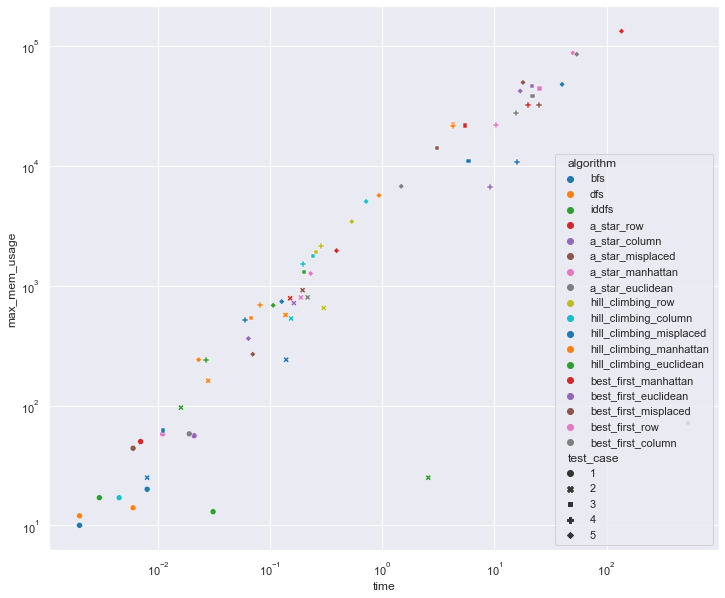

In [290]:
fig, ax = plt.subplots(figsize=(12, 10))
plot = sns.scatterplot(
    data=data,
    x="time",
    y="max_mem_usage",
    hue="algorithm",
    style="test_case",
    palette="tab10",
    ax=ax,
)
plot.set_yscale("log")
plot.set_xscale("log")

## Comparison between algorithms that find the optimal path

Text(0.5, 1.0, 'execution duration in seconds')

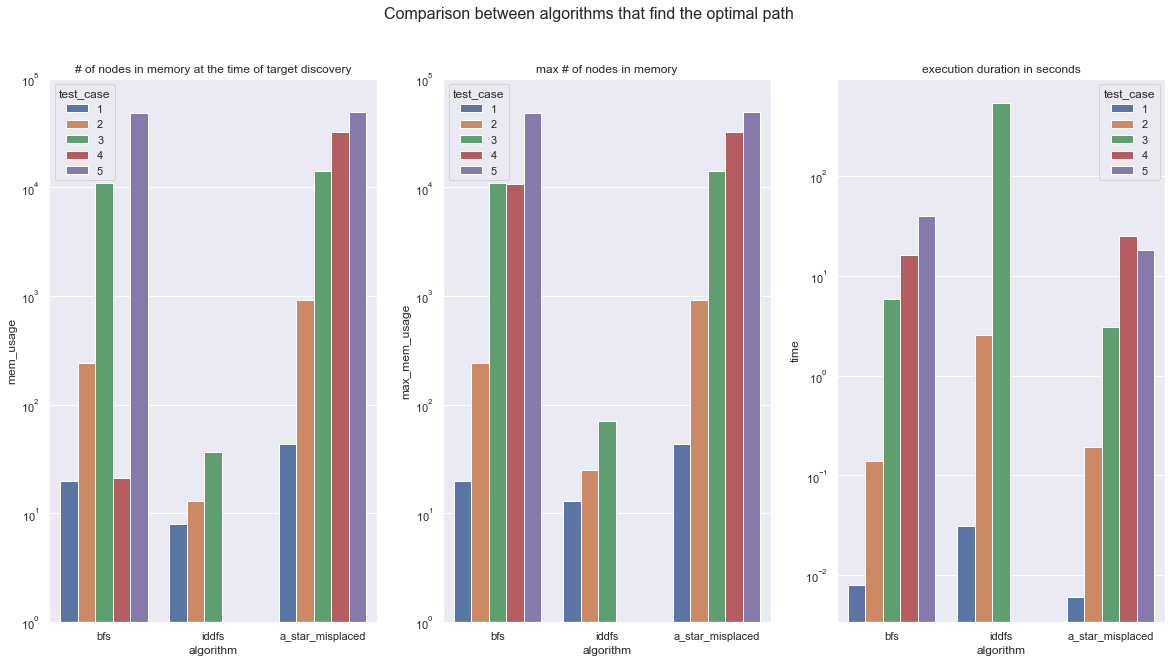

In [198]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle('Comparison between algorithms that find the optimal path', fontsize=16)
temp_data = data[data["algorithm"].isin(("bfs", "a_star_misplaced", "iddfs"))]
plot = sns.barplot(
    data=temp_data,
    x="algorithm",
    y="mem_usage",
    hue="test_case",
    ax=ax[0],
)
plot.set_yscale("log")

plot = sns.barplot(
    data=temp_data,
    x="algorithm",
    y="max_mem_usage",
    hue="test_case",
    ax=ax[1],
)

plot.set_yscale("log")

plot = sns.barplot(
    data=temp_data,
    x="algorithm",
    y="time",
    hue="test_case",
    ax=ax[2],
)

plot.set_yscale("log")

ax[0].set(ylim=(1, 100000))
ax[1].set(ylim=(1, 100000))
ax[0].set_title("# of nodes in memory at the time of target discovery")
ax[1].set_title("max # of nodes in memory")
ax[2].set_title("execution duration in seconds")

## Comparison between different heuristics used for A*

Text(0.5, 1.0, 'execution duration in seconds')

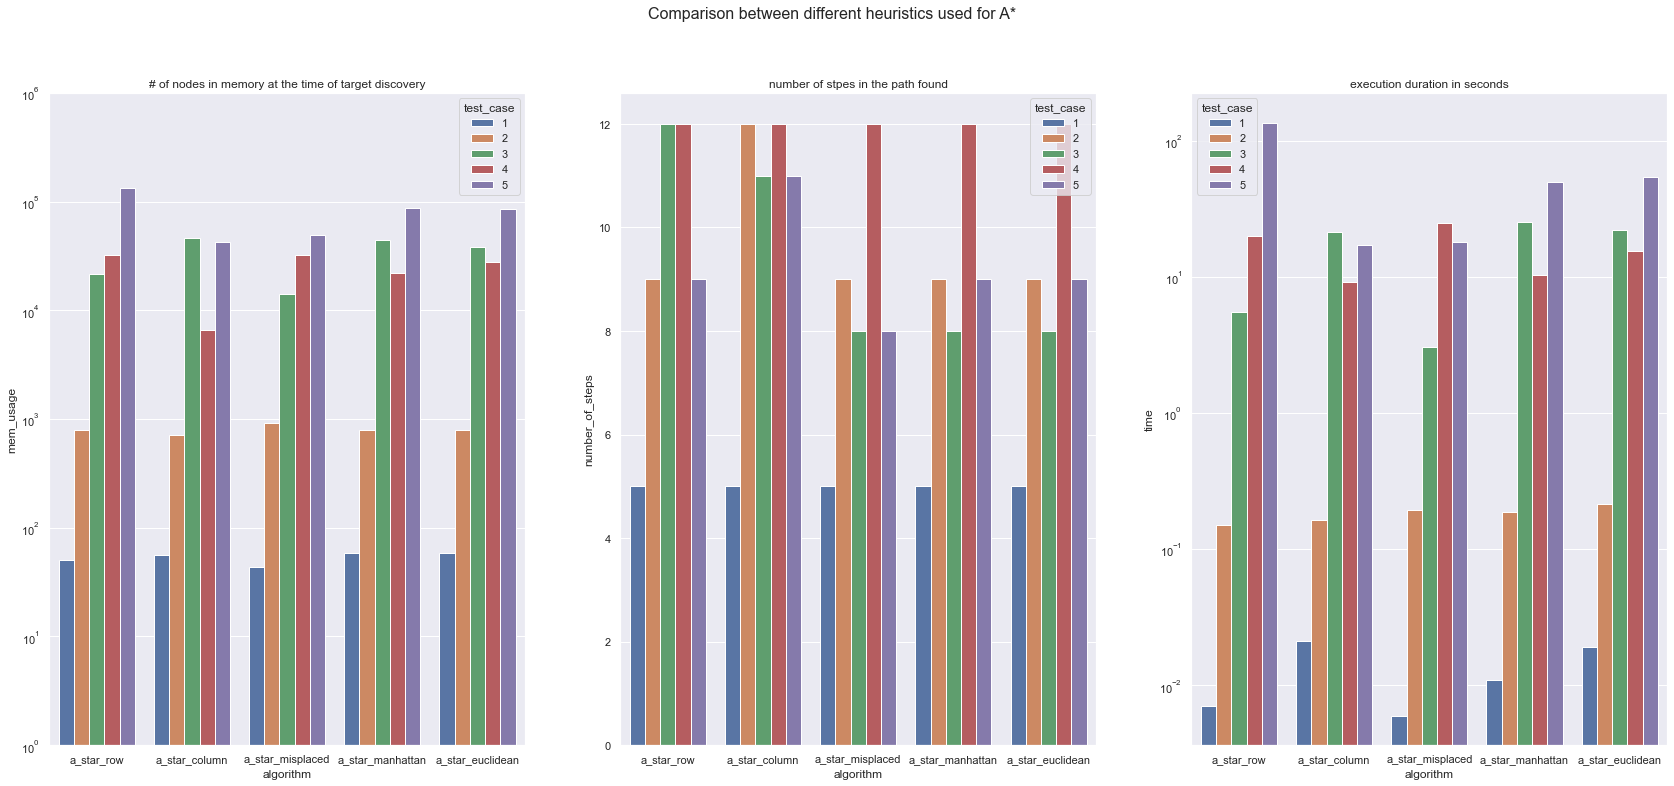

In [223]:
fig, ax = plt.subplots(1, 3, figsize=(29, 12))
fig.suptitle('Comparison between different heuristics used for A*', fontsize=16)
temp_data = data[data["algorithm"].isin(("a_star_misplaced", "a_star_row", "a_star_column", "a_star_manhattan", "a_star_euclidean"))]
plot = sns.barplot(
    data=temp_data,
    x="algorithm",
    y="mem_usage",
    hue="test_case",
    ax=ax[0],
)
plot.set_yscale("log")

plot = sns.barplot(
    data=temp_data,
    x="algorithm",
    y="number_of_steps",
    hue="test_case",
    ax=ax[1],
)

plot = sns.barplot(
    data=temp_data,
    x="algorithm",
    y="time",
    hue="test_case",
    ax=ax[2],
)

plot.set_yscale("log")

ax[0].set(ylim=(1, 1000000))
ax[0].set_title("# of nodes in memory at the time of target discovery")
ax[1].set_title("number of stpes in the path found")
ax[2].set_title("execution duration in seconds")

In [261]:
for i in range(1,6):
    print(f"Test case {i}:")
    temp_data = data[data["test_case"] == i]
    print("MAX max. memory usage")
    print(temp_data.loc[temp_data['max_mem_usage'].idxmax()][["algorithm", "max_mem_usage"]])
    print()
    print("MIN max. memory usage")
    print(temp_data.loc[temp_data['max_mem_usage'].idxmin()][["algorithm", "max_mem_usage"]])
    print()
    print("MAX execution duration")
    print(temp_data.loc[temp_data['time'].idxmax()][["algorithm", "time"]])
    print()
    print("MIN execution duration")
    print(temp_data.loc[temp_data['time'].idxmin()][["algorithm", "time"]])
    print("#############################################")
    print()    

Test case 1:
MAX max. memory usage
algorithm        a_star_manhattan
max_mem_usage                  58
Name: 28, dtype: object

MIN max. memory usage
algorithm        hill_climbing_row
max_mem_usage                   10
Name: 38, dtype: object

MAX execution duration
algorithm      iddfs
time         0.03092
Name: 10, dtype: object

MIN execution duration
algorithm    hill_climbing_row
time                   0.00199
Name: 38, dtype: object
#############################################

Test case 2:
MAX max. memory usage
algorithm        a_star_misplaced
max_mem_usage                 917
Name: 24, dtype: object

MIN max. memory usage
algorithm        iddfs
max_mem_usage       25
Name: 11, dtype: object

MAX execution duration
algorithm      iddfs
time         2.56714
Name: 11, dtype: object

MIN execution duration
algorithm    hill_climbing_misplaced
time                         0.00798
Name: 49, dtype: object
#############################################

Test case 3:
MAX max. memory u